## Learning Rate Scheduler

https://gaussian37.github.io/dl-pytorch-lr_scheduler/

**CosineAnnealingLR**
https://github.com/pytorch/pytorch/blob/v1.1.0/torch/optim/lr_scheduler.py#L222

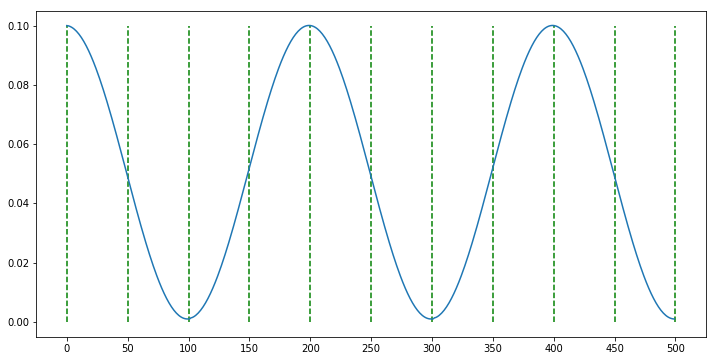

cosine 그래프를 그리면서 learning rate가 진동하는 방식으로 최근에는 learning rate가 단순히 감소하기 보다는 진동하면서 최적점을 찾아가는 방식을 많이 사용한다. Learning Rate가 cosine 함수의 주기에 따라 감소하고 증가하는 과정을 반복한다.

scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

## Training Error와 Generalization Error 사이 간극을 줄이는 방안

여러 모델을 앙상블 하는 방법이 존재한다. 각 모델로 예측한 결과를 앙상블 할 수도 있고 또는 동일 모델로 다른 하이퍼 파라미터를 사용한 모델들의 가중치 자체를 앙상블 하여 사용하는 방법도 존재한다. 물론 이경우 학습 데이터를 각 모델 별로 다르게 사용할 수 있고 모델마다 사용하는 최적화, 규제 방법을 다르게 하는 등 여러 방법으로 앙상블을 진행할 수 있다. 

## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [19]:
pd.read_csv('Train.csv').shape, pd.read_csv('Test.csv').shape

((60000, 785), (10000, 785))

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train['label'].nunique()

10

In [5]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

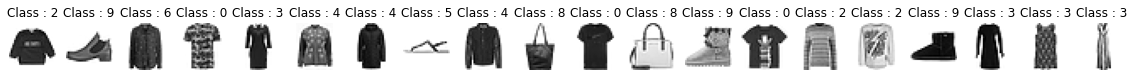

In [7]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
    plt.subplot(1, 20, idx + 1)
    plt.axis('off')
    plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
    plt.title(f'Class : {y[idx]}')

In [8]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

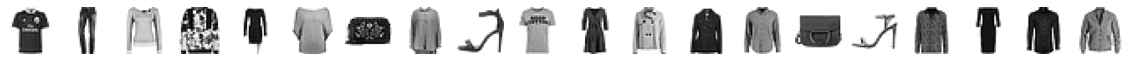

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
    plt.subplot(1, 20, idx + 1)
    plt.axis('off')
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [11]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [12]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
    def __init__(self, image, label = None):
        super(DataSet, self).__init__()
        self._image = image
        self._label = label

    def __len__(self):
        return len(self._image)

    def __getitem__(self, idx):
        if self._label is None:
            image = self._image[idx]
            return image

        else:
            image = self._image[idx]
            label = self._label[idx]

            return image, label

In [15]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [16]:
def train(model, train_loader):
    model.train()
    train_loss = 0
    correct = 0

    for image, label in train_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def pred(model, test_loader):
    model.eval()
    pred_li = []

    with torch.no_grad():
        for image in test_loader:
            image = image.to(DEVICE)
            output = model(image)
            pred_li.append(output.cpu().numpy().argmax(axis=1))

    return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [21]:
import torch.optim as optim

class MyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        
        self.layer1 = nn.Linear(784, 100)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(100, 10)
        
    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        return x
    
model = MyNet().to(DEVICE)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.0011, 	Train Accuracy: 0.24 %, 	Val Loss: 0.4806, 	Val Accuracy: 83.44 % 

[EPOCH: 2], 	Train Loss: 0.0010, 	Train Accuracy: 0.23 %, 	Val Loss: 0.4550, 	Val Accuracy: 84.20 % 

[EPOCH: 3], 	Train Loss: 0.0010, 	Train Accuracy: 0.23 %, 	Val Loss: 0.4043, 	Val Accuracy: 85.87 % 

[EPOCH: 4], 	Train Loss: 0.0006, 	Train Accuracy: 0.25 %, 	Val Loss: 0.3849, 	Val Accuracy: 86.18 % 

[EPOCH: 5], 	Train Loss: 0.0008, 	Train Accuracy: 0.23 %, 	Val Loss: 0.3876, 	Val Accuracy: 86.12 % 

[EPOCH: 6], 	Train Loss: 0.0010, 	Train Accuracy: 0.23 %, 	Val Loss: 0.3763, 	Val Accuracy: 86.09 % 

[EPOCH: 7], 	Train Loss: 0.0007, 	Train Accuracy: 0.24 %, 	Val Loss: 0.3551, 	Val Accuracy: 87.08 % 

[EPOCH: 8], 	Train Loss: 0.0011, 	Train Accuracy: 0.22 %, 	Val Loss: 0.3485, 	Val Accuracy: 87.51 % 

[EPOCH: 9], 	Train Loss: 0.0006, 	Train Accuracy: 0.25 %, 	Val Loss: 0.3389, 	Val Accuracy: 87.61 % 

[EPOCH: 10], 	Train Loss: 0.0005, 	Train Accuracy: 0.25 %, 	Val Loss: 0.3585, 	Val

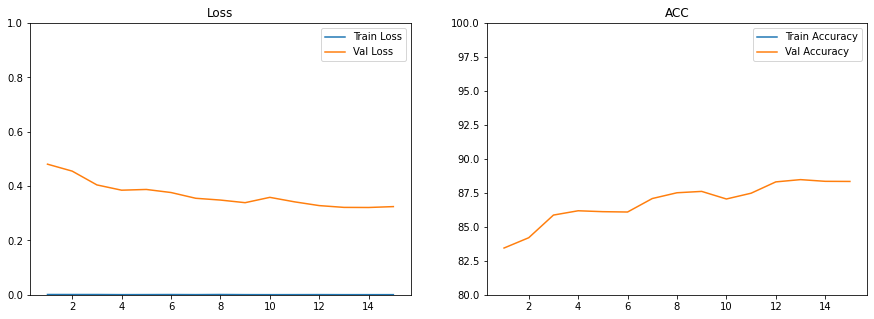

In [22]:
result_list = []
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
    result_list.append(result)

result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

여러 기법을 사용해 간단한 Linear Layer 2개 만으로 Validation Accuracy가 80%가 넘는 좋은 결과를 만들 수 있었다.